In [4]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import interpolate, signal

%matplotlib inline

In [31]:
# some functions used here
def pcoord(x, y):
    """
    Convert x, y to polar coordinates r, az (geographic convention)
    r,az = pcoord(x, y)
    """
    r  = np.sqrt( x**2 + y**2 )
    az = np.degrees( np.arctan2(x, y) )
    # az[where(az<0.)[0]] += 360.
    az = (az+360.)%360.
    return r, az

def xycoord(r, az):
    """
    Convert r, az [degrees, geographic convention] to rectangular coordinates
    x,y = xycoord(r, az)
    """
    x = r * np.sin(np.radians(az))
    y = r * np.cos(np.radians(az))
    return x, y

def buildGrid(xp,yp,alp,dx,dy,mxc,myc):
    '''
    X, Y = buildGrid(xp,yp,alp,dx,dy,mxc,myc) builds a rectangular grid
    
    Input :
        xp: x grid origin
        yp: y grid origin
        alp: degrees rotation of x-axis
        dx: x-direction grid spacing
        dy: y-direction grid spacing
        mxc: number of meshes in x-direction
        myc: number of meshes in y-direction
        
    Based on the Matlab function of Dave Thompson
    '''
    xlen = (mxc-1)*dx
    ylen = (myc-1)*dy
    
    x = np.arange(xp,xp+xlen,dx)
    y = np.arange(yp,yp+ylen,dy)

    X,Y = np.meshgrid(x,y);
    X = X-xp
    Y = Y-yp

    if alp != 0.:
       r,az = pcoord(X,Y)
       X,Y = xycoord(r,az+alp)
        
    X = X+xp
    Y = Y+yp
    return X, Y

In [25]:
# data directory
ddir = r"D:/crs/proj/2015_Sandwich/CCBay_Modeling/"

In [26]:
# load the coarse shoreline
s = np.genfromtxt(ddir+'shoreline.txt', delimiter=',')

In [6]:
# import the fine grid file
p = np.genfromtxt('all_points_xyz.txt', delimiter=',')

In [16]:
# spacing for the three grids
dxyf = 5.
dxym = 35.
dxyc = 245.
# angle of north end

In [39]:
alp = 130.

# make the coarse box
# direction to origin of coarse grid...same angle for base line, even
# increment of dxc
# back calculate location of lower left corner from upper left corner
LMc = 191.
MMc = 67.
xul = 366490.
yul = 4652500.
dxo,dyo = xycoord(MMc*dxyc,alp+90)
xpc = xul+dxo
ypc = yul+dyo

xlenc = LMc*dxyc
ylenc = MMc*dxyc

# box corners
bc = np.empty((4,2),float)
bc[0,:]=[xpc,ypc]
dxb, dyb = xycoord( xlenc, alp );
bc[1,:] = bc[0,:]+[dxb, dyb];
dxb, dyb = xycoord( ylenc, alp-90);
bc[2,:] = bc[1,:]+[dxb, dyb];
dxb, dyb = xycoord( xlenc, alp+180);
bc[3,:] = bc[2,:]+[dxb, dyb]

# make the coarse grid
dxc = dxyc;
dyc = dxyc;
print('Coarse grid is {} x {}, total = {}\n'.format(LMc,MMc,LMc*MMc))
xlenc = LMc*dxc
ylenc = MMc*dyc
X,Y = buildGrid( 0., 0., alp-90., dxc, dyc, LMc, MMc );
X = X + xpc
Y = Y + ypc

Coarse grid is 191.0 x 67.0, total = 12797.0



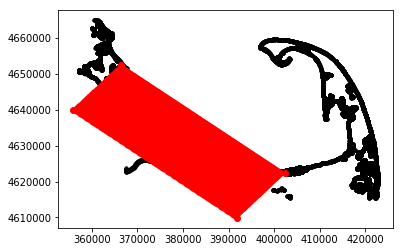

In [37]:
plt.plot(s[:,0],s[:,1],'.k')
plt.plot(bc[:,0],bc[:,1],'or')
plt.plot(bc[:,0],bc[:,1],'-r')
plt.plot([bc[0,0], bc[3,0]],[bc[0,1], bc[3,1]],'-r')
plt.plot(X,Y,'.r')

In [57]:
print(p.shape)
shp = X.shape

(64528617, 3)


In [58]:
%%time
# interpolate data on to coarse grid
z= interpolate.griddata(p[:,0:1], p[:,2], [X, Y], method='linear', fill_value=np.NaN, rescale=False)

Wall time: 11 s


In [59]:
shp = X.shape
print(z.shape)

(2, 66, 190)


ValueError: c of shape (2, 66, 190) not acceptable as a color sequence for x with size 12540, y with size 12540

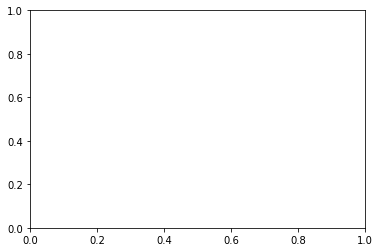

In [60]:
plt.scatter(X,Y,16,z)